In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools
from collections import defaultdict 
import numpy as np
from snpp.utils.matrix import load_sparse_csr, \
    split_train_test
from snpp.utils.signed_graph import matrix2graph


dataset = 'epinions'
raw_mat_path = 'data/{}.npz'.format(dataset)
random_seed = 123456

In [3]:
m = load_sparse_csr(raw_mat_path)

print('split_train_test')
train_m, test_m = split_train_test(
    m,
    weights=[0.9, 0.1])

test_entries = set(tuple(sorted((i, j)))
                   for i, j in zip(*test_m.nonzero()))
g = matrix2graph(m, None)

split_train_test


1278it [00:00, 6344.07it/s]

building MultiGraph


841372it [03:24, 4106.54it/s]


In [4]:
# getting all triangles
nodes_nbrs = g.adj.items()

triangles = set()
for v, v_nbrs in tqdm(nodes_nbrs):
    vs = set(v_nbrs) - set([v])
    ntriangles = 0
    for w in vs:
        ws = set(g[w]) - set([w])
        for u in vs.intersection(ws):
            triangles.add(tuple(sorted([u, v, w])))
        
print("{} triangles".format(len(triangles)))

100%|██████████| 131828/131828 [02:07<00:00, 1035.59it/s]

4910076 triangles


In [5]:
triangle_order_cnt = np.zeros(4)
for t in tqdm(triangles):
    its = filter(lambda e: tuple(sorted(e)) in test_entries,
                 itertools.combinations(t, 2))
    triangle_order_cnt[len(list(its))] += 1

print('the percetange of 0, 1, 2, 3-order triangles:')
print(triangle_order_cnt / np.sum(triangle_order_cnt) * 100)

100%|██████████| 4910076/4910076 [00:50<00:00, 97802.16it/s] 

the percetange of 0, 1, 2, 3-order triangles:
[ 65.26021186  29.81945697   4.66593592   0.25439525]


In [6]:
edge2triangle_order = defaultdict(lambda: np.zeros(4))
for t in tqdm(triangles):
    edges = list(filter(lambda e: tuple(sorted(e)) in test_entries,
                       itertools.combinations(t, 2)))
    for e in edges:
       edge2triangle_order[e][len(edges)] += 1
    
m = np.array(list(edge2triangle_order.values()))
print(m.shape)

print('mean of triangle order count on edges: {}'.format(np.mean(m, axis=0)))
print('median of triangle order count on edges: {}'.format(np.median(m, axis=0)))
print('std of triangle order count on edges: {}'.format(np.std(m, axis=0)))
print('max of triangle order count on edges: {}'.format(np.max(m, axis=0)))
print('min of triangle order count on edges: {}'.format(np.min(m, axis=0)))
                                                                 


100%|██████████| 4910076/4910076 [00:44<00:00, 110050.18it/s]

(65650, 4)
mean of triangle order count on edges: [  0.          22.30248286   6.97946687   0.5707997 ]
median of triangle order count on edges: [ 0.  8.  2.  0.]
std of triangle order count on edges: [  0.          35.43107472  12.05992168   1.30934553]
max of triangle order count on edges: [    0.  1505.   346.    20.]
min of triangle order count on edges: [ 0.  0.  0.  0.]


In [7]:
print('triangle count mean: {}'.format(np.mean(m.sum(axis=1))))
print('triangle count median: {}'.format(np.median(m.sum(axis=1))))
print('triangle count max: {}'.format(np.max(m.sum(axis=1))))

triangle count mean: 29.852749428789032
triangle count median: 11.0
triangle count max: 1869.0


In [8]:
print("#edges with at least 1 triangles: {}".format(m.shape[0]))
print("#edges without any triangles: {}".format(len(test_entries) - m.shape[0]))

#edges with at least 1 triangles: 65650
#edges without any triangles: 17129


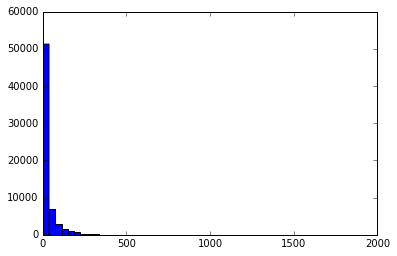

In [9]:
triangle_counts = m.sum(axis=1)
plt.hist(triangle_counts, 50)
plt.show()

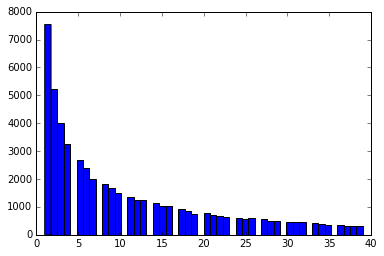

In [10]:
plt.hist(triangle_counts[triangle_counts < 40], 50)
plt.show()